# Model evaluation 31D

This notebook is used to visualize the compression errors of a specific AE trained on a 31-dimensional jet dataset.

In [1]:
import os
import uproot
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import corner

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

import vector

import glob

In [2]:
plt.rcParams.update({'font.size': 16, 'lines.markersize' : 10, 'image.cmap' : 'tab20b'})

In [3]:
# Set up branch information

# Specify whether to include calculated energy or mass as the fourth four-momentum variable
b_file = open('branches_E.txt', 'r')
#b_file = open('branches_m.txt', 'r')

branches = []
for line in b_file.readlines():
    if line[0] != '#':
        branches.append(line.replace('\n', ''))
b_file.close()
print('Number of branches selected:', len(branches), '\n')
res_type = pd.read_pickle('res_types.pkl')
for branch in branches:
    print('{:>30} - {:20}'.format(branch, res_type[branch]))

Number of branches selected: 31 

     JetEtaJESScaleMomentum_pt - response            
    JetEtaJESScaleMomentum_eta - residual            
    JetEtaJESScaleMomentum_phi - residual            
                  Calculated_E - response            
                    ActiveArea - residual            
             ActiveArea4vec_pt - residual            
            ActiveArea4vec_eta - residual            
            ActiveArea4vec_phi - residual            
              ActiveArea4vec_m - residual            
                  AverageLArQF - response            
                     NegativeE - response            
                    LArQuality - residual            
                         Width - residual            
                      WidthPhi - residual            
                     CentroidR - response            
                   DetectorEta - residual            
    LeadingClusterCenterLambda - response            
              LeadingClusterPt - response       

# Viewing the results of a single model

In [4]:
# Visualize resulting distributions

path = r'F:\Master\Data\storage\orig-pred'
filename = 'run_20211024192654_same_event_1_24_orig-pred.pkl'

(orig, pred) = pd.read_pickle(os.sep.join([path, filename]))

In [5]:
units = ['[MeV]',
         '',
         '[rad]',
         '[MeV]',
         '',
         '',
         '',
         '',
         '',
         '',
         '[MeV]',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '',
         '[ns]',
         '',
         '',
         '',
         '',
         '[rad]',
         '',
         '',
         '']
branch_units = dict(zip(branches, units))

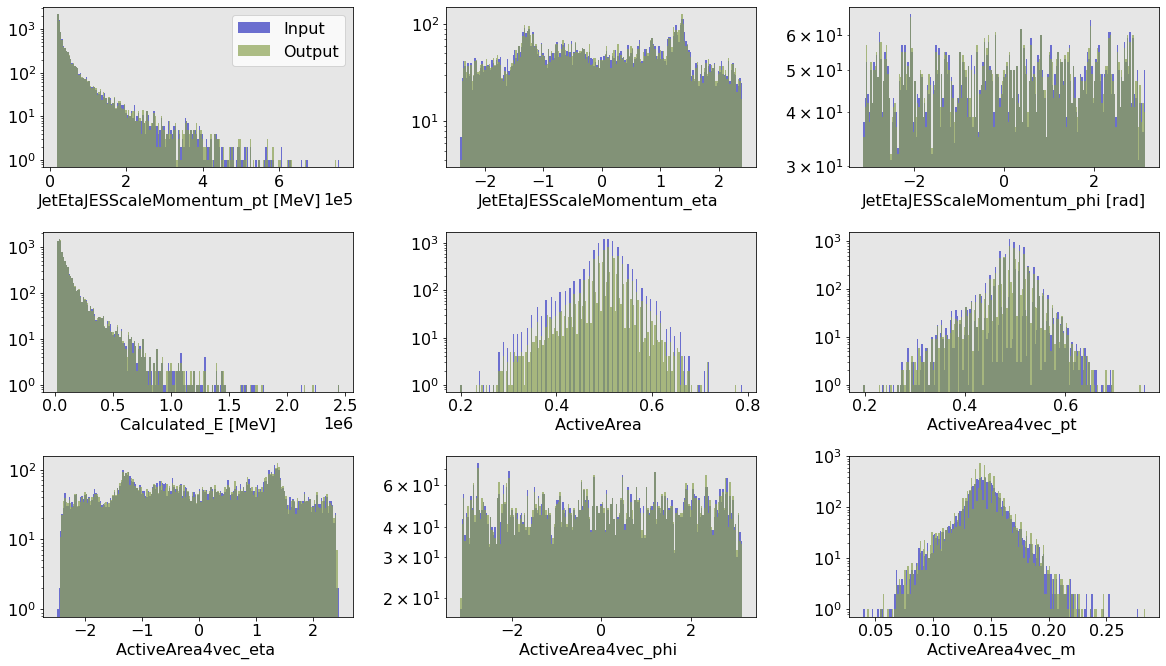

In [95]:
n_bins = 200
cmap = plt.get_cmap('tab20b')
colors = [cmap.colors[2], cmap.colors[5]]

selected_branches = branches[:9]
fig = plt.figure(figsize=(20, 4*len(selected_branches)))
for i, branch in enumerate(selected_branches):
    plt.subplot(len(selected_branches), 3, i+1)
    limits = (min(min(orig[branch]), min(pred[branch])), max(max(orig[branch]), max(pred[branch])))
    bins = np.linspace(limits[0], limits[1], n_bins)
    _ = plt.hist(orig[branch], bins=bins, density=False, color=colors[0])
    _ = plt.hist(pred[branch], bins=bins, density=False, color=colors[1], alpha=0.7)
    xlims = plt.xlim()
    sci = False
    if xlims[0] < -10000 or xlims[1] > 10000:
        plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
        sci = True
    if i in [0, 9, 18]:
        plt.legend(['Input', 'Output'], loc=0)
    if i == 30:
        plt.legend(['Input', 'Output'], loc=3)
    xlabel = branch + ' ' + branch_units[branch]
    if len(xlabel) > 28 and sci:
        plt.xlabel(xlabel, position=(.5 - .02 * (len(xlabel) - 28), 0))
    else:
        plt.xlabel(xlabel)
    plt.yscale('log')
    plt.gca().set_facecolor((0.9, 0.9, 0.9))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

In [6]:
# Calculate responses and residuals

res = pred - orig
for column in res.columns:
    if res_type[column] == 'response':
        res[column] = res[column] / orig[column]

n_bins = 200

#ranges = [(min(res[branch]), max(res[branch])) for branch in branches]
#limits = [np.linspace(a, b, n_bins) for (a, b) in ranges]
#limits = [np.linspace(a, b, n_bins) for (a, b) in [(-0.05, 0.05), (-0.05, 0.05), (-0.04, 0.04), (-0.02, 0.02), (-0.03, 0.03), (-0.03, 0.03)]]

bin_edges = {}
bin_counts = {}
bin_max_ixs = {}
masks = {}

percentiles = {}
percentile_values = [0.5, 99.5]

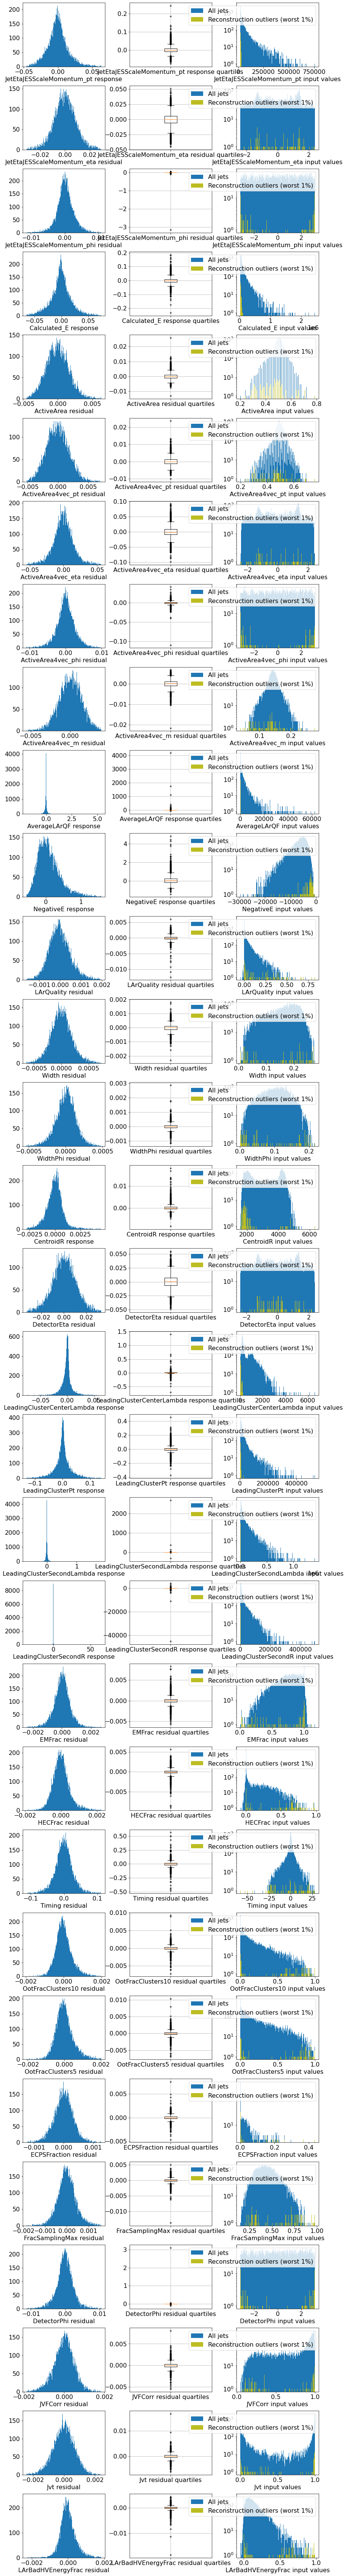

In [7]:
# more detailed error visualization. This was ultimately not used in the thesis report

fig = plt.figure(figsize=(14, 4*len(branches)))
for i, branch in enumerate(branches):
    
    percentiles[branch] = np.percentile(res[branch], percentile_values)
    masks[branch] = (res[branch] < percentiles[branch][1]) & (res[branch] > percentiles[branch][0])
    mask = masks[branch]
    
    # Res plot
    bins = np.linspace(percentiles[branch][0], percentiles[branch][1], n_bins)
    plt.subplot(len(branches), 3, 3*i+1)
    bin_counts[branch], bin_edges[branch], _ = plt.hist(res[branch][mask], bins=bins, density=False)
    bin_max_ixs[branch] = np.where(bin_counts[branch] == bin_counts[branch].max())  
    plt.xlabel(branch + ' ' + res_type[branch])
    #plt.yscale('log')
    
    # Box plot
    plt.subplot(len(branches), 3, 3*i+2)
    box = plt.boxplot(res[branch], sym='.', labels=[branch + ' ' + res_type[branch] + ' quartiles'])
    plt.grid()

    # Original distribution
    plt.subplot(len(branches), 3, 3*i+3)
    counts, edges, _ = plt.hist(orig[branch], bins=n_bins, label='All jets')
    plt.hist(orig[branch][~mask], bins=edges, label='Reconstruction outliers (worst 1%)', color='tab:olive')
    plt.xlabel(branch + ' input values')
    plt.legend()
    plt.yscale('log')
    
    #print(branch + ' ' + res_type[branch] + ' mean:', res[branch].mean())
    #print(branch + ' ' + res_type[branch] + ' std:', res[branch].std())
    #print()
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [8]:
total_masking = np.array([True] * len(res))
print('Total number of jets:', sum(total_masking))
for branch in branches:
    total_masking = total_masking & masks[branch]
    print('Mask progression...', sum(total_masking))
print('Total number of jets:', len(res))
print('Number of jets with NO values in 1% extreme range:', sum(total_masking))

Total number of jets: 6464
Mask progression... 6398
Mask progression... 6335
Mask progression... 6280
Mask progression... 6229
Mask progression... 6169
Mask progression... 6143
Mask progression... 6104
Mask progression... 6082
Mask progression... 6071
Mask progression... 6012
Mask progression... 5959
Mask progression... 5923
Mask progression... 5897
Mask progression... 5876
Mask progression... 5845
Mask progression... 5819
Mask progression... 5770
Mask progression... 5734
Mask progression... 5687
Mask progression... 5677
Mask progression... 5656
Mask progression... 5634
Mask progression... 5592
Mask progression... 5577
Mask progression... 5567
Mask progression... 5528
Mask progression... 5511
Mask progression... 5504
Mask progression... 5492
Mask progression... 5484
Mask progression... 5467
Total number of jets: 6464
Number of jets with NO values in 1% extreme range: 5467


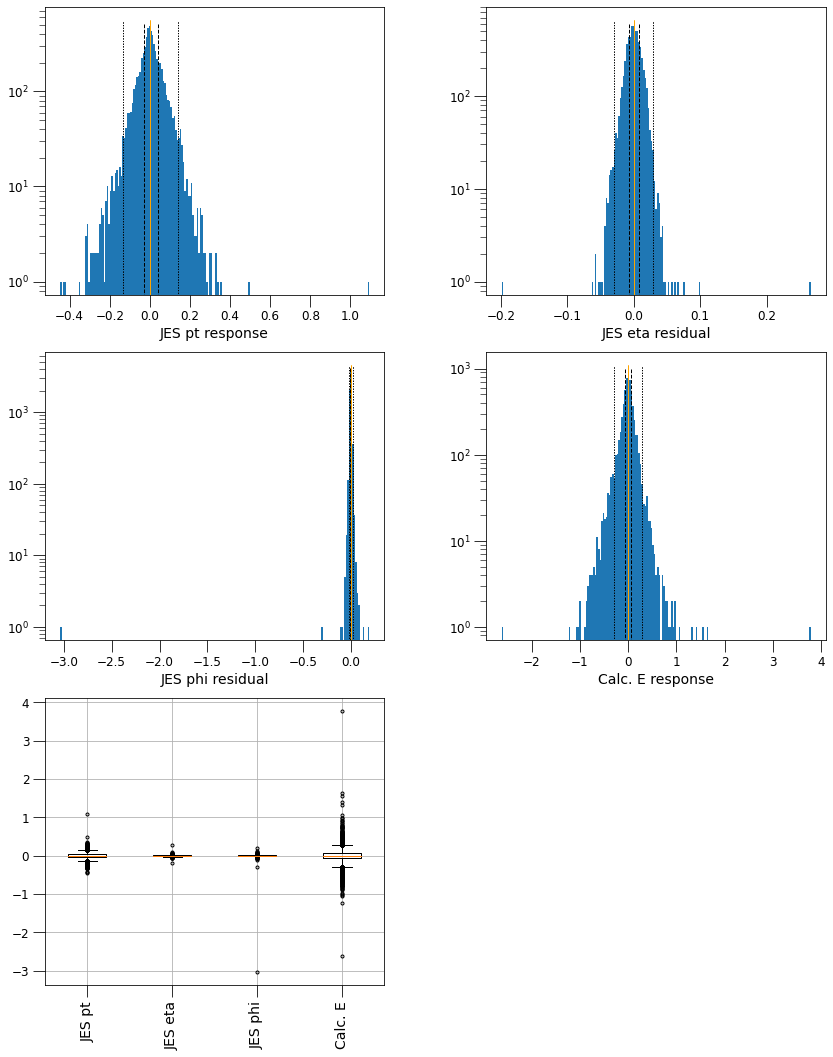

In [9]:
reduced_branches = ['JetEtaJESScaleMomentum_pt', 'JetEtaJESScaleMomentum_eta', 'JetEtaJESScaleMomentum_phi', 'Calculated_E']
short_four_branches = ['JES pt', 'JES eta', 'JES phi', 'Calc. E']
short_reduced_branches = {reduced_branches[i] : short_four_branches[i] for i in range(len(reduced_branches))}
n_bins = 200
include = 1

fig = plt.figure(figsize=(14, 18))
ax2 = fig.add_subplot(3, 2, 5)
box = plt.boxplot(res[reduced_branches], sym='.', labels=short_reduced_branches.values())
plt.grid()

for i, branch in enumerate(reduced_branches):
    ax1 = fig.add_subplot(3, 2, i+1)
    mask = np.abs(res[branch]) <= include * np.abs(res[branch]).max()
    limits = np.linspace(min(res[branch][mask]), max(res[branch][mask]), n_bins)
    counts, edges, _ = plt.hist(res[branch][mask], bins=limits, density=False)
    
    plt.vlines(box['boxes'][i].get_ydata()[[0, 2]], ymax=ax1.get_ylim()[0], ymin=ax1.get_ylim()[1], linestyles='dashed', color='k', linewidth=1)
    plt.vlines([box['caps'][2*i].get_ydata(), box['caps'][2*i+1].get_ydata()], ymax=ax1.get_ylim()[0], ymin=ax1.get_ylim()[1], linestyles='dotted', color='k', linewidth=1)
    plt.vlines(box['medians'][i].get_ydata(), ymax=ax1.get_ylim()[0], ymin=ax1.get_ylim()[1], color='orange', linewidth=1)
    
    plt.xlabel(short_reduced_branches[branch] + ' ' + res_type[branch])
    plt.yscale('log')
    ax1.set_xlabel(ax1.get_xlabel(), fontsize=14)
    ax1.set_ylabel(ax1.get_ylabel(), fontsize=12)
    ax1.tick_params(axis='both', which='minor', size=6, labelsize=12)
    ax1.tick_params(axis='both', which='major', size=12, labelsize=12)
    #ax1.legend(fontsize=12)

ax2.set_ylabel(ax2.get_ylabel(), fontsize=12)
ax2.tick_params(axis='both', which='minor', size=6, labelsize=12)
ax2.tick_params(axis='y', which='major', size=12, labelsize=12)
ax2.tick_params(axis='x', which='major', size=12, labelsize=14)
ax2.tick_params(axis='x', rotation=90)
#ax2.set_yticks(np.arange(-.1, .11, .05))
#ax2.set_yticks(np.arange(-.1, .11, .025), minor=True)
ax2.grid(which='minor', linestyle=':')
#ax2.legend(fontsize=12)

#title_str = 'Group size: ' + str(group_size) + ', # jet features: ' + str(n_features) + ', input size: ' + str(group_size*n_features) + ', latent space size: ' + str(latent_space_size) + ', jet selection: ' + prop
#fig.suptitle(title_str);
plt.subplots_adjust(wspace=0.3)